# Project 3 - Spatial Analyis and Spatial Auto-correlation
### Lorn Jaeger


### View 1
Display of basic data.

Show WSTS raster, MTBS perimeters, and WUI shapefiles QGIS screenshots.

### View 2
fdsafdsafd
Preprocess data and join it into a single table

### View 3

Check if fires closer to civilization have more fires burnt. Are they in the same distribution?


### View 4
fd
Train a regular regression model and see if the fires close to cities perform worse.

### View 5

Try again with all the data and see if any fires improve. See which fires they are as well.

Using raster: data/2021/fire_25548074/2021-10-04.tif


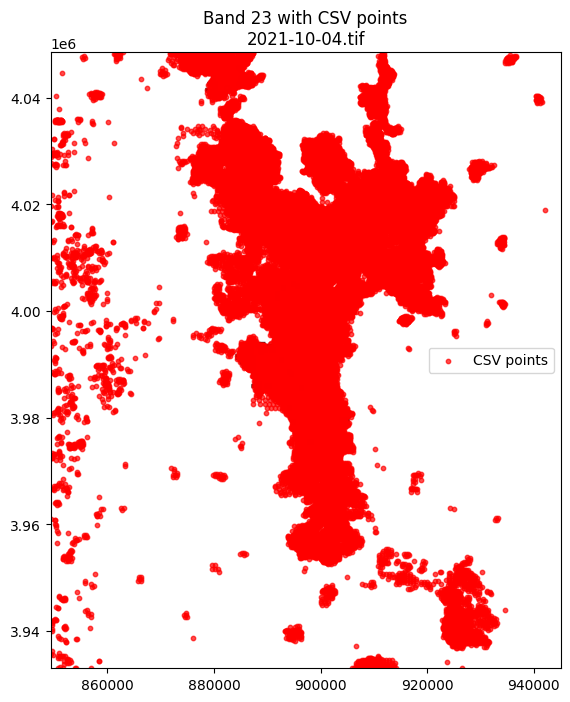

In [18]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from pathlib import Path
import random

np.
# Paths
base_dir = Path("data")
csv_path = "data/viirs.csv"

# Sample a few rasters until we find one with valid band 23 data
files = list(base_dir.glob("20*/fire*/*.tif"))
random.shuffle(files)

raster_path = None
for tiff_path in files:
    with rasterio.open(tiff_path) as src:
        band23 = src.read(23, masked=True)
        if (~band23.mask).any():
            raster_path = tiff_path
            break

if raster_path is None:
    raise RuntimeError("No rasters found with valid data in band 23")

print(f"Using raster: {raster_path}")

# Load raster
with rasterio.open(raster_path) as src:
    band_23 = src.read(23).astype(float)
    bounds = src.bounds
    crs = src.crs
    transform = src.transform
    nodata = src.nodata

# Replace nodata with NaN and rescale for visibility
if nodata is not None:
    band_23[band_23 == nodata] = np.nan
band_vis = np.clip(band_23, np.nanpercentile(band_23, 2), np.nanpercentile(band_23, 98))

# Load CSV
df = pd.read_csv(csv_path)
if {'latitude', 'longitude'}.issubset(df.columns):
    lats, lons = df['latitude'].values, df['longitude'].values
elif {'lat', 'lon'}.issubset(df.columns):
    lats, lons = df['lat'].values, df['lon'].values
else:
    raise ValueError("CSV must have latitude/longitude columns")

# Transform CSV coords (assuming WGS84)
transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
xs, ys = transformer.transform(lons, lats)

# Keep only points inside raster bounds
mask = (
    (xs >= bounds.left) &
    (xs <= bounds.right) &
    (ys >= bounds.bottom) &
    (ys <= bounds.top)
)

# Plot
plt.figure(figsize=(10, 8))
plt.title(f"Band 23 with CSV points\n{raster_path.name}")
plt.imshow(
    band_vis,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper",
    cmap="gray"
)
plt.scatter(xs[mask], ys[mask], s=10, c='red', alpha=0.7, label='CSV points')
plt.legend()
plt.show()




Using raster: data/2022/fire_TX2680709766220220324/2022-03-29.tif


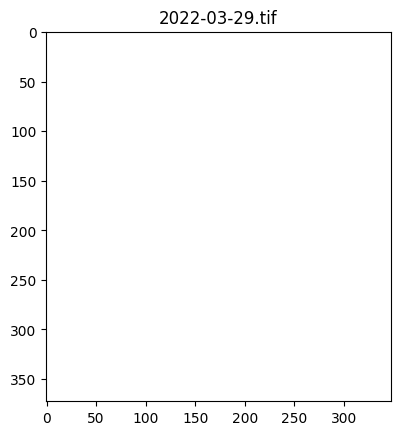

Valid (non-NaN) pixels: 0 / 129804


In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

files = list(Path("data").glob("20*/fire*/*.tif"))
random.shuffle(files)

for tiff_path in files:
    with rasterio.open(tiff_path) as src:
        band23 = src.read(23, masked=True)
        if (~band23.mask).any():
            raster_path = tiff_path
            break

print("Using raster:", raster_path)

with rasterio.open(raster_path) as src:
    band = src.read(23).astype(float)
    if src.nodata is not None:
        band[band == src.nodata] = np.nan

plt.imshow(band, cmap="gray")
plt.title(raster_path.name)
plt.show()

valid_count = np.isfinite(band).sum()
total_count = band.size
print(f"Valid (non-NaN) pixels: {valid_count} / {total_count}")



In [20]:
vals = band_23[np.isfinite(band_23)]
print(np.unique(vals[:20]))


[1012.]


/home/lorn/Code/wsts-regression/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


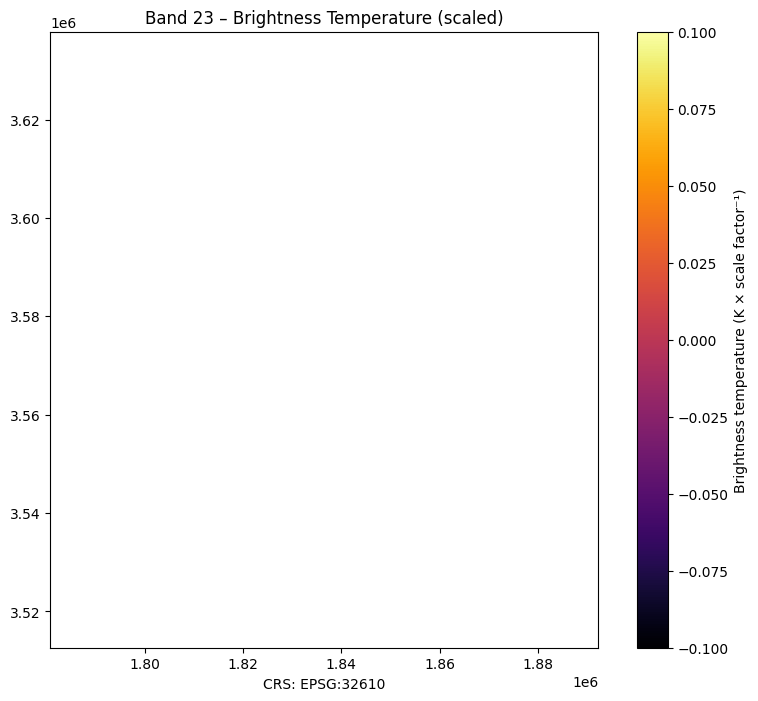

In [21]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

raster_path = "data/2022/fire_NM3151410902420220529/2022-06-10.tif"

with rasterio.open(raster_path) as src:
    band_23 = src.read(23).astype(float)
    bounds = src.bounds
    crs = src.crs
    transform = src.transform
    nodata = src.nodata

# Replace nodata values with NaN
if nodata is not None:
    band_23[band_23 == nodata] = np.nan

# Optional: apply scale factor if known
scale_factor = 10  # adjust if metadata shows a different one
band_23 /= scale_factor

# Clip to 2–98 percentile for better contrast
band_vis = np.clip(band_23, np.nanpercentile(band_23, 2), np.nanpercentile(band_23, 98))

plt.figure(figsize=(10, 8))
plt.title("Band 23 – Brightness Temperature (scaled)")
plt.imshow(
    band_vis,
    extent=[bounds.left, bounds.right, bounds.bottom, bounds.top],
    origin="upper",
    cmap="inferno"
)
cbar = plt.colorbar(label="Brightness temperature (K × scale factor⁻¹)")
plt.xlabel(f"CRS: {crs}")
plt.ylabel("")
plt.show()
